# Data Driven: Pump It Up (1/3)

**Vilhelm Stiernstedt & Camillo Baratta**
<br>
** Date: 14/03/2018**

** Instructions **
<br>
Using data from Taarifa and the Tanzanian Ministry of Water, can you predict which pumps are functional, which need some repairs, and which don't work at all? This is an intermediate-level practice competition. Predict one of these three classes based on a number of variables about what kind of pump is operating, when it was installed, and how it is managed. A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania.
<br>
<br>
** Goal **
<br>
Your goal is to predict the operating condition of a waterpoint for each record in the dataset.
The labels in this dataset are simple. There are three possible values:

- functional - the waterpoint is operational and there are no repairs needed
- functional needs repair - the waterpoint is operational, but needs repairs
- non functional - the waterpoint is not operational

**Plan**
1. Import libraries
2. Import data
3. Data description
4. Feature analysis
5. Data cleaning
    - Impute missing values
    - Outlier treatment
6. Feature engineering
    - Transformation
    - Binning
    - New features
7. Feature selection
    - Drop irrelevant features
8. Modelling Preparation
    - One-hot encoding
    - Test/train split
9. Modelling
    - Randomforest model
    - Light GBM
    - KNN
    - LDA
    - LR-OVR (OneVsAll)
    - Stacked Model
10. Submission

<br>
** Notebooks used in project:**
<br>
The different steps are distrubuted over 3 notebooks:
1. Data Analysis - step 1-4 (Pump_Data_Analysis)
2. Data Preparation - steps 5-8 (Pump_Data_Preparation)
3. Data Modelling - steps 9-10 (Pump_Models)

## 1. Import Libaries & Settings

In [3]:
# Import libaries
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint
import seaborn as sns

# Pandas settings
pd.set_option('display.max_columns', 100)

# Plot settings
%matplotlib inline

## 2. Import Data
1. Load csv files:
    - train_values
    - train_labels
    - test_values
2. Merge train_values and train_labels into **train** - use this df for all data analysis.
3. Merge train with test_values into **all_data** - use this df for all cleaning and then split train and test before modelling.
3. Write files to csv for storage.

In [4]:
# Data Processing
# Import data
train_values = pd.read_csv("data/train_set_values.csv", sep=",")
train_labels = pd.read_csv("data/train_set_labels.csv", sep=",")
test = pd.read_csv("data/test.csv", sep=",")

# Merge train with train_labels
train = train_values.merge(train_labels, on='id', how='inner')

# Merge train with test_values
all_data = train.append(test)

# Set  id index
all_data.set_index('id', inplace=True)
train_labels.set_index('id', inplace=True)
train.set_index('id', inplace=True)
test.set_index('id', inplace=True)

# Write to csv
#train.to_csv('data/train.csv', sep=',')
#test.to_csv('data/test.csv', sep=',')
#all_data.to_csv('data/all_data.csv', sep=',')

## 3. Data Description
1. Establish data types
2. Transform data types if necessary
3. Create dfs for numerical and categorical variables
4. Inspect numerical variables
5. Inspect categorical variables
6. Group parameters

In [5]:
# Show datatype of all variables
all_data.dtypes.sort_values()

population                 int64
construction_year          int64
region_code                int64
district_code              int64
num_private                int64
gps_height                 int64
amount_tsh               float64
longitude                float64
latitude                 float64
status_group              object
source_class              object
quantity_group            object
source                    object
subvillage                object
scheme_name               object
scheme_management         object
ward                      object
water_quality             object
region                    object
recorded_by               object
waterpoint_type           object
source_type               object
quantity                  object
permit                    object
public_meeting            object
waterpoint_type_group     object
payment_type              object
payment                   object
management_group          object
management                object
lga       

### Transform data types
date_recorded -> string to datetime

In [6]:
# Transform dtypes
# Numerical to datetime (Year-MM-DD)
all_data.date_recorded = pd.to_datetime(all_data.date_recorded,
                                        errors='ignore',
                                        format='%Y-%m-%d')

train.date_recorded = pd.to_datetime(train.date_recorded,
                                     errors='ignore',
                                     format='%Y-%m-%d')

test.date_recorded = pd.to_datetime(test.date_recorded,
                                    errors='ignore',
                                    format='%Y-%m-%d')

### Create dfs for numerical and categorical variables

In [7]:
# Subset data for categorical Values
all_cat_vars = all_data.select_dtypes(include=['object'])

# Subset data for numerical values
all_num_vars = all_data.select_dtypes(exclude=['object'])

### Inspect numercial variables

In [8]:
# Describe numerical variables
all_num_vars.describe()

,amount_tsh,construction_year,district_code,gps_height,latitude,longitude,num_private,population,region_code
count,74250.000000,74250.000000,74250.000000,74250.000000,7.425000e+04,74250.000000,74250.000000,74250.000000,74250.000000
mean,318.685704,1298.463650,5.629077,665.667313,-5.701771e+00,34.074262,0.462330,180.750828,15.265414
std,2906.762364,952.349375,9.641636,692.761033,2.944969e+00,6.572519,11.537879,471.086120,17.508907
min,0.000000,0.000000,0.000000,-90.000000,-1.164944e+01,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,2.000000,0.000000,-8.525675e+00,33.086819,0.000000,0.000000,5.000000
50%,0.000000,1986.000000,3.000000,364.000000,-5.026540e+00,34.907475,0.000000,25.000000,12.000000
75%,20.000000,2004.000000,5.000000,1317.000000,-3.325058e+00,37.181685,0.000000,215.000000,17.000000
max,350000.000000,2013.000000,80.000000,2777.000000,-2.000000e-08,40.345193,1776.000000,30500.000000,99.000000


### Inspect categorical variables

In [9]:
# Describe categorical variables
all_cat_vars.describe()

,basin,extraction_type,extraction_type_class,extraction_type_group,funder,installer,lga,management,management_group,payment,payment_type,permit,public_meeting,quality_group,quantity,quantity_group,recorded_by,region,scheme_management,scheme_name,source,source_class,source_type,status_group,subvillage,ward,water_quality,waterpoint_type,waterpoint_type_group,wpt_name
count,74250,74250,74250,74250,69746,69718,74250,74250,74250,74250,74250,70457,70095,74250,74250,74250,74250,74250,69404,38992,74250,74250,74250,59400,73780,74250,74250,74250,74250,74250
unique,9,18,7,13,2140,2410,125,12,5,7,7,2,2,6,5,5,1,21,12,2868,10,3,7,3,21425,2098,8,7,6,45684
top,Lake Victoria,gravity,gravity,gravity,Government Of Tanzania,DWE,Njombe,vwc,user-group,never pay,never pay,True,True,good,enough,enough,GeoData Consultants Ltd,Iringa,VWC,K,spring,groundwater,spring,functional,Shuleni,Igosi,soft,communal standpipe,communal standpipe,none
freq,12871,33263,33263,33263,11299,21751,3128,50624,65538,31712,31712,48606,63749,63505,41522,41522,74250,6599,45917,858,21216,57286,21216,32259,646,386,63505,35628,43239,4440


### Group Parameters

**Target Paramenter**
- status_group

**Well Parameters**
- amount_tsh (water remaining)
- basin
- construction_year
- extraction_type_class
- extraction_type
- extraction_type_group
- gps_height
- quantity
- quantity_group 
- source 
- source_type
- source_class
- wpt_name
- water_quality
- quality_group 
- waterpoint_type
- waterpoint_type_group 

**Time Parameters**
- date_recorded

**Demographic Parameters**
- population

**Economic Parameters**
- payment 
- payment_type

**Legal Parameters**
- permit

**Geographic Parameters**
- basin (water reserve of well: supply)
- region
- lga (town name)
- region_code
- district_code
- latitude (well)
- longitude (well)
- ward 
- subvillage

**Organizational Parameters**
- scheme_management
- funder
- installer
- scheme_name
- management 
- management_group 
- recorded_by

## 4. Feature Analysis
Go through each group of features and perform the following operations:
1. Univariate analysis
2. Multivariate analysis

### status_group (target variable)

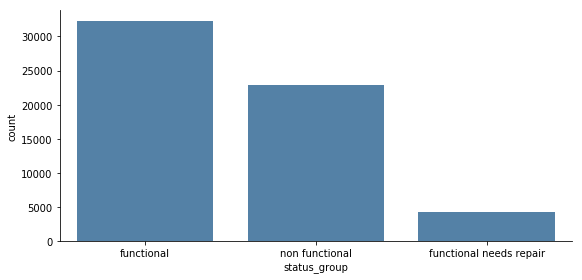

In [10]:
# Barplot to show distrubution of each level
g = sns.factorplot("status_group", data=train, aspect=2,
                   kind="count", color='steelblue')
g.set_xticklabels(step=1, rotation=0);

In [11]:
# value count
train.status_group.value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [12]:
# Count NAs for train just to reassure nothing missing
train.status_group.isnull().sum()

0

## well_parameters

### amount_tsh

1. Analysis - Majority zero values
2. Transform with log10 to normalize distrubution
3. Create new feature: log_amount_tsh

In [13]:
# overall info
train.amount_tsh.describe()
# -> large IQR, mode = 0

count     59400.000000
mean        317.650385
std        2997.574558
min           0.000000
25%           0.000000
50%           0.000000
75%          20.000000
max      350000.000000
Name: amount_tsh, dtype: float64

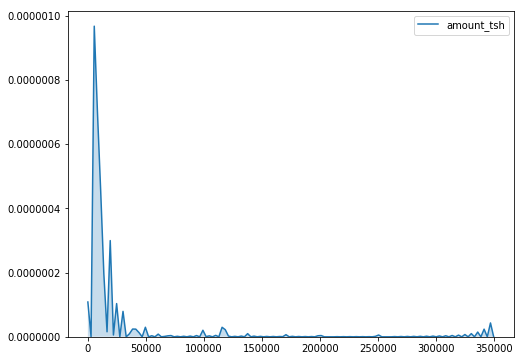

In [14]:
# KDEplot to see distrubution -> zero values -> very skewed
fig, ax = plt.subplots(figsize=(8, 6))
sns.kdeplot(train['amount_tsh'], shade=True);

In [15]:
# Vast number of rows where value = 0 --> need to impute these values
all_data[all_data['amount_tsh'] == 0].amount_tsh.count()

52049

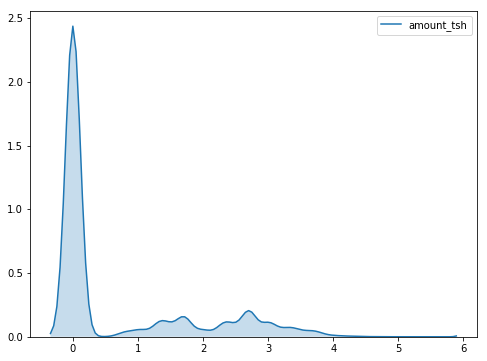

In [16]:
# Transform to log10 to get better view -> much better results
# KDEplot
fig, ax = plt.subplots(figsize=(8, 6))
sns.kdeplot(np.log10(train['amount_tsh'] + 1), shade=True);

In [17]:
# Missing values -> no need to impute NaNs
all_data.amount_tsh.isnull().sum()

0

/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


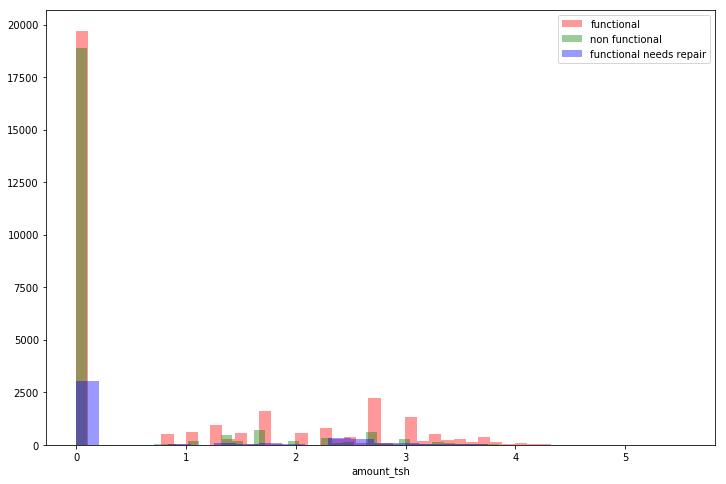

In [18]:
# See distrubtion of log amount_tsh vs status_group -> no clear relationship
plot_df = pd.concat([train.status_group, np.log10(train.amount_tsh + 1)], axis=1)

fig, ax = plt.subplots(figsize=(12, 8))

sns.distplot(plot_df[(plot_df.status_group == 'functional')].amount_tsh,
             kde=False, color='r',
             label="functional")

sns.distplot(plot_df[(plot_df.status_group == 'non functional')].amount_tsh,
             kde=False, color='g',
             label="non functional")

sns.distplot(plot_df[(plot_df.status_group == 'functional needs repair')].amount_tsh,
             kde=False, color='b',
             label="functional needs repair")

plt.legend();

### basin
1. Analysis -> lake victoria most common basin
2. No specific relationship with status_group

In [19]:
# Overall info
train.basin.describe()

count             59400
unique                9
top       Lake Victoria
freq              10248
Name: basin, dtype: object

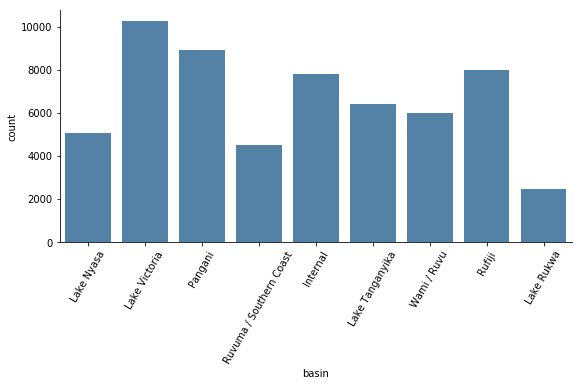

In [20]:
# Barplot to show distrubution of each level
g = sns.factorplot("basin", data=train, aspect=2,
                   kind="count", color='steelblue')
g.set_xticklabels(step=1, rotation=60);

In [21]:
# Value count
train.basin.value_counts()

Lake Victoria              10248
Pangani                     8940
Rufiji                      7976
Internal                    7785
Lake Tanganyika             6432
Wami / Ruvu                 5987
Lake Nyasa                  5085
Ruvuma / Southern Coast     4493
Lake Rukwa                  2454
Name: basin, dtype: int64

In [22]:
# Missing values -> no need to impute
all_data.basin.isnull().sum()

0

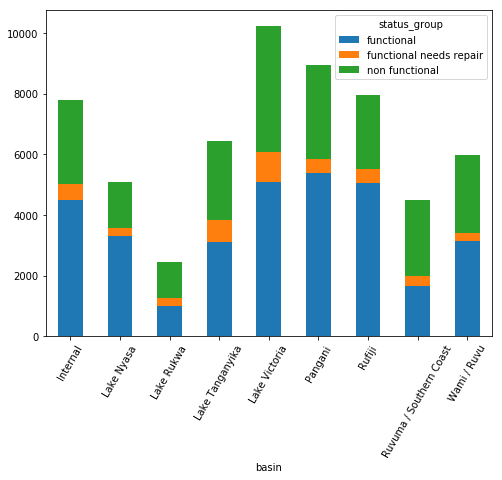

In [23]:
# See distrubtion vs status_group -> no clear relationship
plot_df = train.groupby(['basin','status_group']).status_group.count().unstack()
plot_df.plot(kind='bar', stacked=True, figsize=(8, 6), rot=60);

#Note: given that fuctional has the clear mayority in status group, its good to see that functional waterpoints seem
#      to be relatively evenly distributed across basins (functional is usually the clear majority except in Ruvuma)

### construction_year
1. Analysis -> alot of zero values (34%)
2. Clear relationship with status_group -> newer more functional
3. Impute zero values

In [24]:
# Overall info
train.construction_year.describe()

count    59400.000000
mean      1300.652475
std        951.620547
min          0.000000
25%          0.000000
50%       1986.000000
75%       2004.000000
max       2013.000000
Name: construction_year, dtype: float64

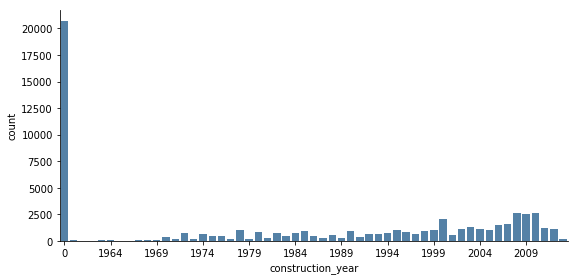

In [25]:
# Plot -> a lot of zeros
g = sns.factorplot("construction_year", data=train, aspect=2,
                   kind="count", color='steelblue')

g.set_xticklabels(step=5, rotation=0);

In [26]:
# Proportion of zeros
tmp = train[train['construction_year'] == 0].construction_year.count() / len(train)
tmp

0.34863636363636363

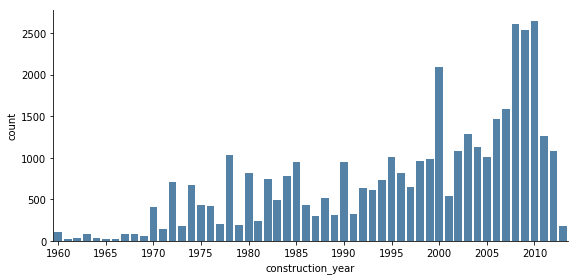

In [27]:
# Plot -> filter for non zero years
plot_df = train[(train.construction_year) > 0]

g = sns.factorplot("construction_year", data=plot_df, aspect=2,
                   kind="count", color='steelblue')

g.set_xticklabels(step=5, rotation=0);

In [28]:
# Missing values
all_data.construction_year.isnull().sum()

0

/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


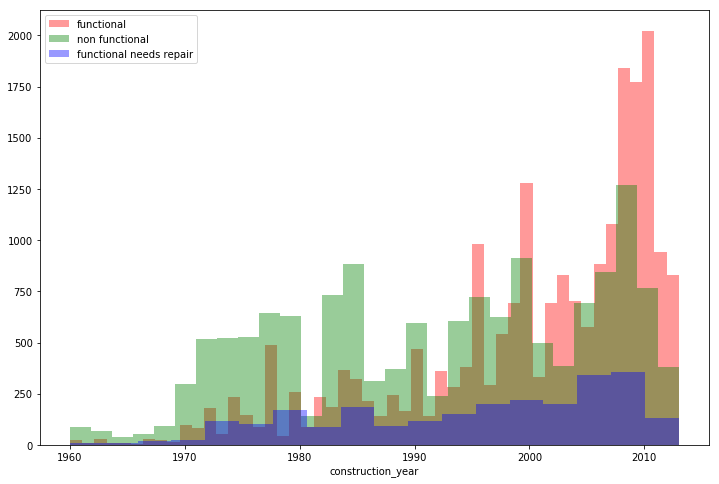

In [29]:
# histogram with construction_year by status_group -> clear relationship with status_group
# newer equals higher chance of functional
plot_df = train[(train.construction_year) > 0]

fig, ax = plt.subplots(figsize=(12, 8))

sns.distplot(plot_df[(plot_df.status_group == 'functional')].construction_year,
             kde=False, color='r',
             label="functional")

sns.distplot(plot_df[(plot_df.status_group == 'non functional')].construction_year,
             kde=False, color='g',
             label="non functional")

sns.distplot(plot_df[(plot_df.status_group == 'functional needs repair')].construction_year,
             kde=False, color='b',
             label="functional needs repair")

plt.legend();

### extraction_type_class
1. what to do with it "other"?
2. transform into ordinal variable (1,2,3,4,...)?


In [30]:
# overall info
train.extraction_type_class.describe()

count       59400
unique          7
top       gravity
freq        26780
Name: extraction_type_class, dtype: object

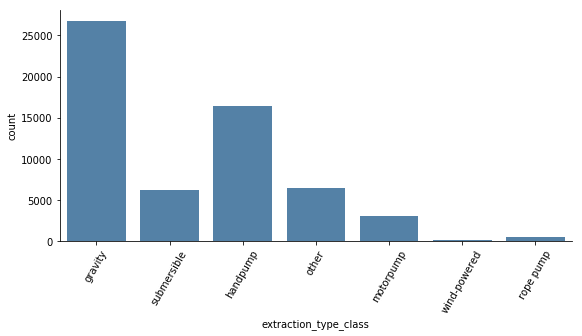

In [31]:
# Barplot to show distrubution of each level
g = sns.factorplot("extraction_type_class", data=train, aspect=2,
                   kind="count", color='steelblue')
g.set_xticklabels(step=1, rotation=60);

In [32]:
# value Count
train.extraction_type_class.value_counts()

gravity         26780
handpump        16456
other            6430
submersible      6179
motorpump        2987
rope pump         451
wind-powered      117
Name: extraction_type_class, dtype: int64

In [33]:
# missing Values
all_data.extraction_type_class.isnull().sum()

0

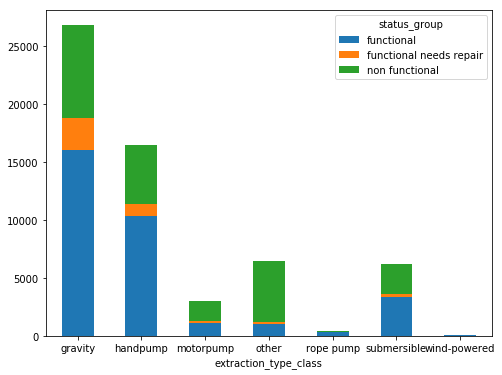

In [34]:
# See distrubtion vs status_group -> non-functional higher proportion others, motorpump, submersible
plot_df = train.groupby(['extraction_type_class','status_group']).status_group.count().unstack()
plot_df.plot(kind='bar', stacked=True, figsize=(8, 6), rot=0);

In [35]:
train.groupby(['extraction_type_class','status_group']).status_group.count().unstack()

status_group,functional,functional needs repair,non functional
extraction_type_class,,,
gravity,16048,2701,8031
handpump,10375,995,5086
motorpump,1135,138,1714
other,1029,206,5195
rope pump,293,17,141
submersible,3329,253,2597
wind-powered,50,7,60


### extraction_type

In [36]:
# overall info
train.extraction_type.describe()

count       59400
unique         18
top       gravity
freq        26780
Name: extraction_type, dtype: object

In [37]:
# value Count
train.extraction_type.value_counts()

gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

In [38]:
# does other in extraction_type also equal other in extraction_type_class and extraction_type_group? -> no!
train[(train.extraction_type == 'other') &
      (train.extraction_type_class != 'other') &
      (train.extraction_type_group != 'other')]

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [39]:
# missing Values
all_data.extraction_type.isnull().sum()

0

In [40]:
# -> no need to clean anything
# -> delete variable - > extraction_type_class more consistent information

### extraction_type_group

In [41]:
# overall info
train.extraction_type_group.describe()

count       59400
unique         13
top       gravity
freq        26780
Name: extraction_type_group, dtype: object

In [42]:
# value Count
train.extraction_type_group.value_counts()

gravity            26780
nira/tanira         8154
other               6430
submersible         6179
swn 80              3670
mono                2865
india mark ii       2400
afridev             1770
rope pump            451
other handpump       364
other motorpump      122
wind-powered         117
india mark iii        98
Name: extraction_type_group, dtype: int64

In [43]:
# missing Values
all_data.extraction_type_group.isnull().sum()

0

In [44]:
# -> no need to clean anything
# -> delete variable - > extraction_type_class more consistent information

### gps_height

In [45]:
# overall info
train.gps_height.describe()

count    59400.000000
mean       668.297239
std        693.116350
min        -90.000000
25%          0.000000
50%        369.000000
75%       1319.250000
max       2770.000000
Name: gps_height, dtype: float64

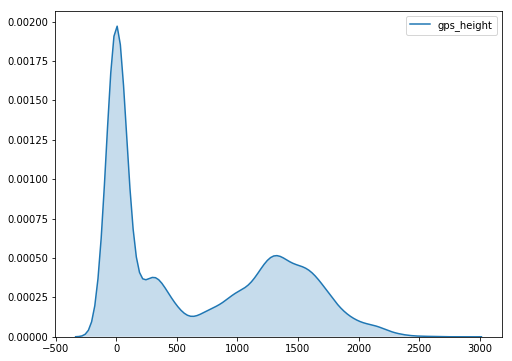

In [46]:
# histogram -> a lot of zeros for quite moutainous country
fig, ax = plt.subplots(figsize=(8, 6))
sns.kdeplot(train['gps_height'], shade=True);

In [47]:
# zero values -> need to impute some zeros
train[train.gps_height == 0].gps_height.count()

20438

In [48]:
# missing values
all_data.gps_height.isnull().sum()
# -> no NAs

0

/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


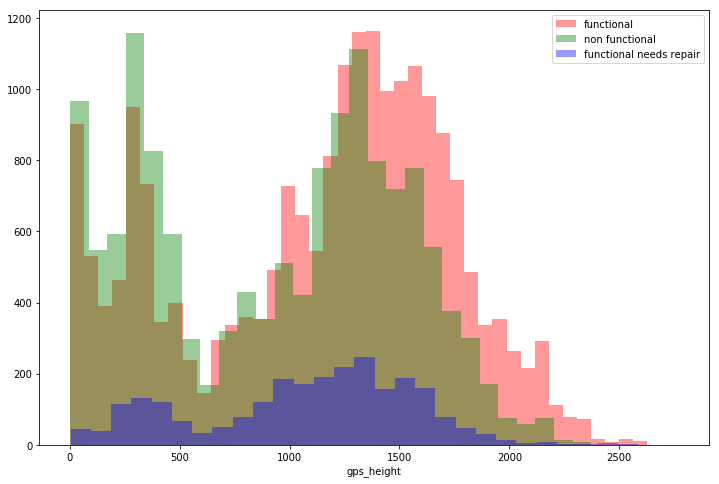

In [49]:
# status_group vs gps_height > 0
plot_df = train[(train.gps_height) > 0]

fig, ax = plt.subplots(figsize=(12, 8))

sns.distplot(plot_df[(plot_df.status_group == 'functional')].gps_height,
             kde=False, color='r',
             label="functional")

sns.distplot(plot_df[(plot_df.status_group == 'non functional')].gps_height,
             kde=False, color='g',
             label="non functional")

sns.distplot(plot_df[(plot_df.status_group == 'functional needs repair')].gps_height,
             kde=False, color='b',
             label="functional needs repair")

plt.legend();
# no super clear correlation between altitude and status

### quantity

In [50]:
# overall info
train.quantity.describe()

count      59400
unique         5
top       enough
freq       33186
Name: quantity, dtype: object

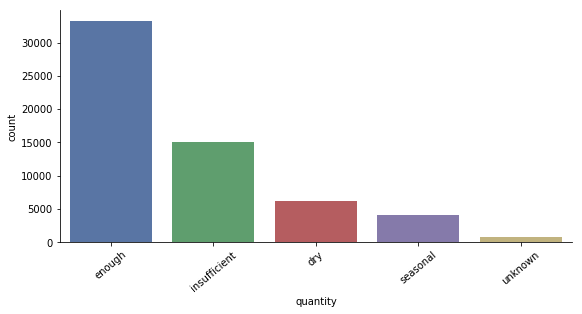

In [51]:
# plot of distrubution ->
g = sns.factorplot("quantity", data=train, aspect=2,
                   kind="count", palette='deep')

g.set_xticklabels(step=1, rotation=40);

In [52]:
# value Count
train.quantity.value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64

In [53]:
# missing Values
all_data.quantity.isnull().sum()

0

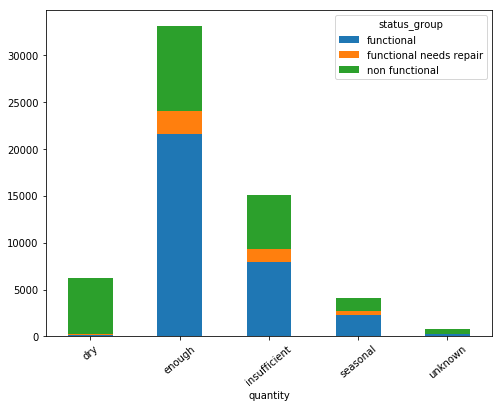

In [54]:
# Stacked plot with status_group -> clear relationship between non-functional and dry, unknown
plot_df = train.groupby(['quantity', 'status_group']) \
               .quantity \
               .count() \
               .unstack()

plot_df.plot(kind='bar', stacked=True, figsize=(8, 6), rot=40);

In [55]:
train.groupby(['quantity', 'status_group']) \
               .quantity \
               .count() \
               .unstack()

status_group,functional,functional needs repair,non functional
quantity,,,
dry,157,37,6052
enough,21648,2400,9138
insufficient,7916,1450,5763
seasonal,2325,416,1309
unknown,213,14,562


### quantity_group

In [56]:
# overall info
train.quantity_group.describe()

count      59400
unique         5
top       enough
freq       33186
Name: quantity_group, dtype: object

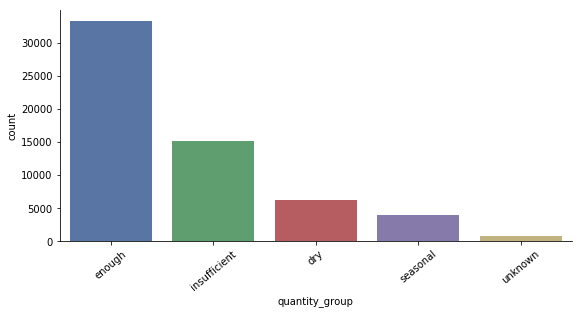

In [57]:
# plot of distrubution -> just like quantity -> drop variable
g = sns.factorplot("quantity_group", data=train, aspect=2,
                   kind="count", palette='deep')

g.set_xticklabels(step=1, rotation=40);

### source

In [58]:
# overall info
train.source.describe()

count      59400
unique        10
top       spring
freq       17021
Name: source, dtype: object

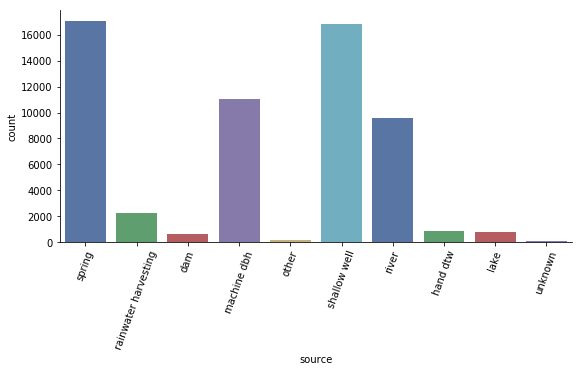

In [59]:
# plots
g = sns.factorplot('source', data=train, aspect=2,
                   kind="count", palette='deep')

g.set_xticklabels(step=1, rotation=70);

In [60]:
# value Count
train.source.value_counts()

spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: source, dtype: int64

In [61]:
# missing Values
all_data.source.isnull().sum()

0

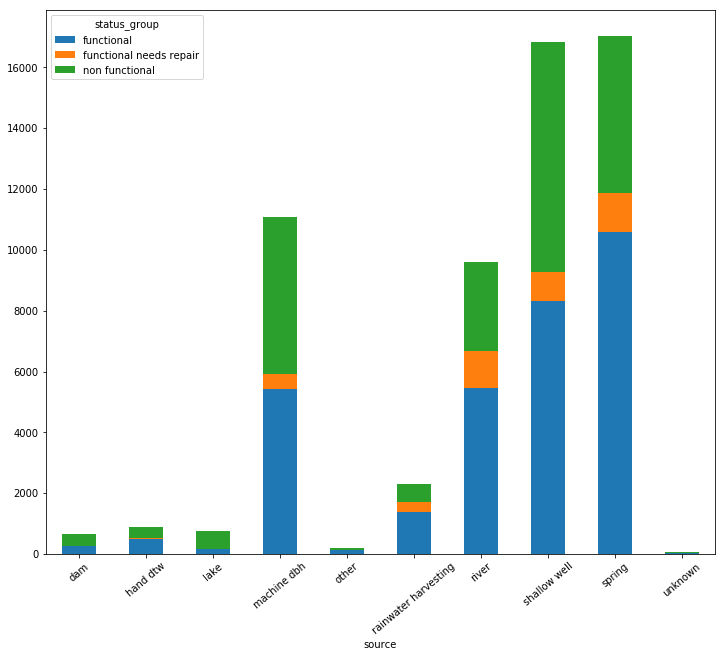

In [62]:
# Stacked plot with status_group 
plot_df = train.groupby(['source', 'status_group']) \
               .quantity \
               .count() \
               .unstack()

plot_df.plot(kind='bar', stacked=True, figsize=(12, 10), rot=40);

In [63]:
train.groupby(['source', 'status_group']).quantity.count().unstack()

status_group,functional,functional needs repair,non functional
source,,,
dam,253,24,379
hand dtw,497,17,360
lake,162,12,591
machine dbh,5422,491,5162
other,126,1,85
rainwater harvesting,1386,314,595
river,5465,1221,2926
shallow well,8324,957,7543
spring,10592,1276,5153


more non-functional:
- machine dbh
- lake
- dam
- shallow well
- unknown 

### source_type
1. keep instead of source

In [64]:
# overall info
train.source_type.describe()

count      59400
unique         7
top       spring
freq       17021
Name: source_type, dtype: object

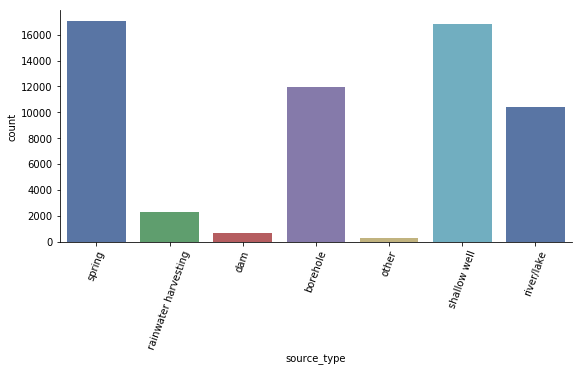

In [65]:
# plot
g = sns.factorplot('source_type', data=train, aspect=2,
                   kind="count", palette='deep')

g.set_xticklabels(step=1, rotation=70);

In [66]:
# value Count -> same as source but not unknowns
train.source_type.value_counts()

spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64

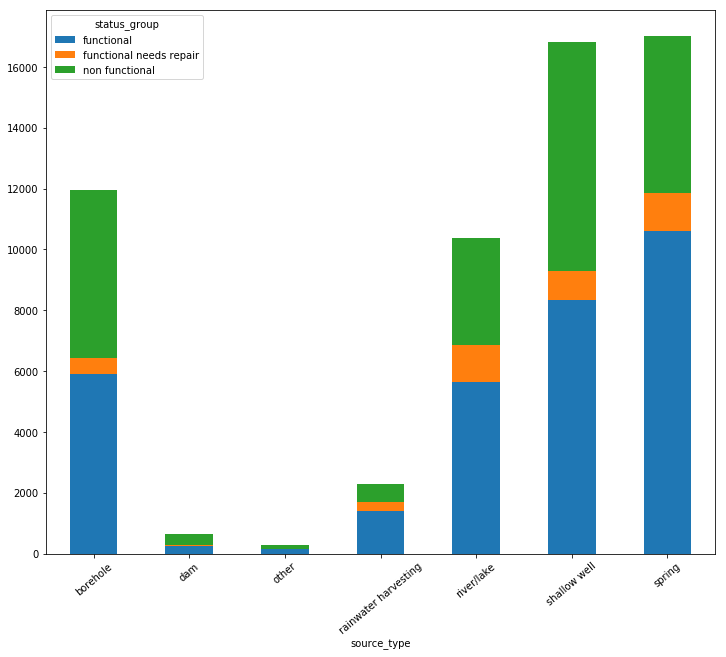

In [67]:
# Stacked plot with status_group ->
plot_df = train.groupby(['source_type', 'status_group']) \
               .quantity \
               .count() \
               .unstack()

plot_df.plot(kind='bar', stacked=True, figsize=(12, 10), rot=40);

### source_class
1. Less granular than source_type

In [68]:
# overall info
train.source_class.describe()

count           59400
unique              3
top       groundwater
freq            45794
Name: source_class, dtype: object

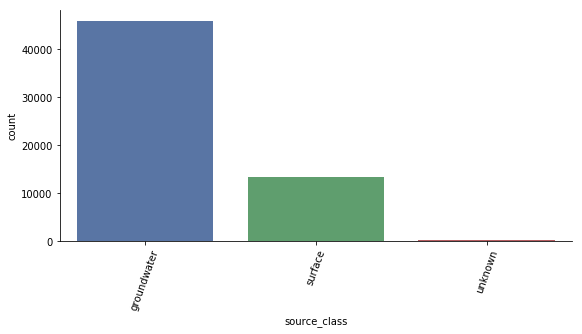

In [69]:
# plots
g = sns.factorplot('source_class', data=train, aspect=2,
                   kind="count", palette='deep')

g.set_xticklabels(step=1, rotation=70);

In [70]:
# missing values
all_data.source_class.isnull().sum()

0

### wpt_name

In [71]:
# overall info
train.wpt_name.describe()

count     59400
unique    37400
top        none
freq       3563
Name: wpt_name, dtype: object

In [72]:
# value Count 
train.wpt_name.value_counts().head(20)

none               3563
Shuleni            1748
Zahanati            830
Msikitini           535
Kanisani            323
Bombani             271
Sokoni              260
Ofisini             254
School              208
Shule Ya Msingi     199
Shule               152
Sekondari           146
Muungano            133
Mkombozi            111
Madukani            104
Hospital             94
Mbugani              94
Upendo               93
Kituo Cha Afya       90
Mkuyuni              88
Name: wpt_name, dtype: int64

In [73]:
# -> alot of nones
# -> impute or drop? 
# -> transform binary, name or no name (inc. none)

In [74]:
# missing Values
all_data.wpt_name.isnull().sum()

0

### water_quality

In [75]:
# overall info
train.water_quality.describe()

count     59400
unique        8
top        soft
freq      50818
Name: water_quality, dtype: object

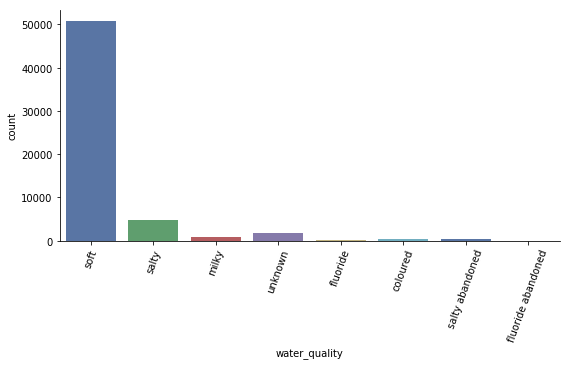

In [76]:
# plot
g = sns.factorplot('water_quality', data=train, aspect=2,
                   kind="count", palette='deep')

g.set_xticklabels(step=1, rotation=70);

In [77]:
# value Count -> mostly soft
train.water_quality.value_counts()

soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64

In [78]:
# missing Values
all_data.water_quality.isnull().sum()

0

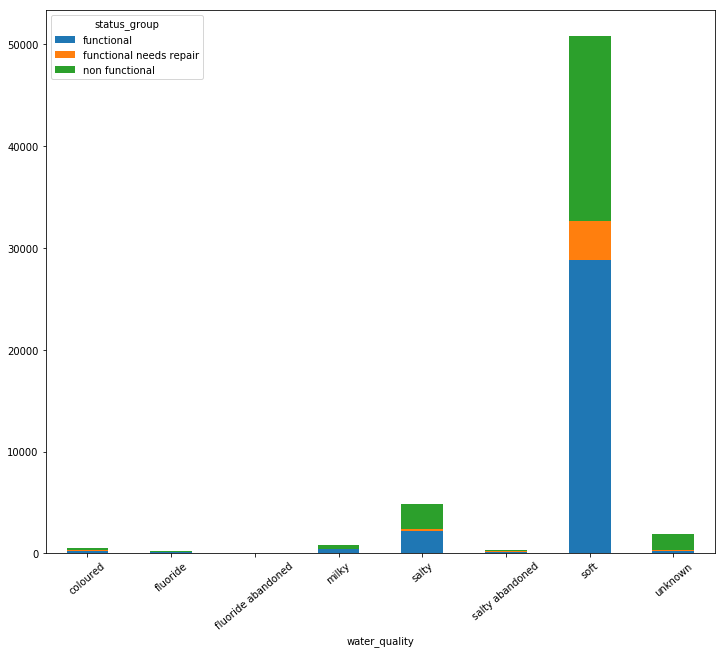

In [79]:
# Stacked plot with status_group -> unknown higher proportion of non-functional
plot_df = train.groupby(['water_quality', 'status_group']) \
               .quantity \
               .count() \
               .unstack()

plot_df.plot(kind='bar', stacked=True, figsize=(12, 10), rot=40);

In [80]:
train.groupby(['water_quality', 'status_group']) \
               .quantity \
               .count() \
               .unstack()

status_group,functional,functional needs repair,non functional
water_quality,,,
coloured,246.0,54.0,190.0
fluoride,151.0,13.0,36.0
fluoride abandoned,6.0,NaN,11.0
milky,438.0,14.0,352.0
salty,2220.0,225.0,2411.0
salty abandoned,174.0,72.0,93.0
soft,28760.0,3904.0,18154.0
unknown,264.0,35.0,1577.0


### quality_group

In [81]:
# overall info
train.quality_group.describe()

count     59400
unique        6
top        good
freq      50818
Name: quality_group, dtype: object

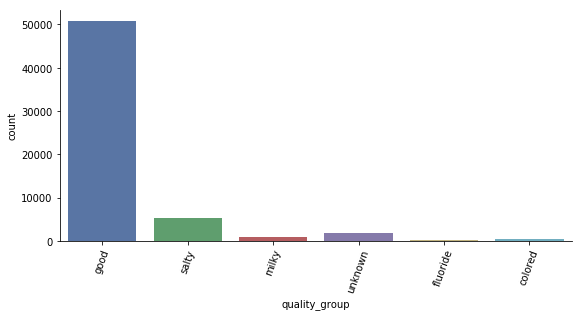

In [82]:
# plot -> soft change name to good 
g = sns.factorplot('quality_group', data=train, aspect=2,
                   kind="count", palette='deep')

g.set_xticklabels(step=1, rotation=70);

In [83]:
# value Count
train.quality_group.value_counts()

good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
Name: quality_group, dtype: int64

In [84]:
# missing Values
all_data.quality_group.isnull().sum()

0

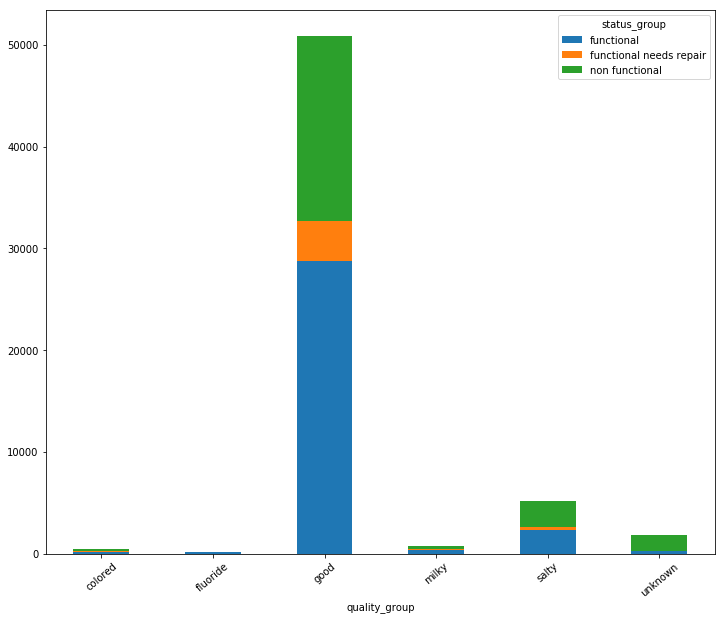

In [85]:
# Stacked plot with status_group -> unknown higher proportion of non-functional
plot_df = train.groupby(['quality_group', 'status_group']) \
               .quantity \
               .count() \
               .unstack()

plot_df.plot(kind='bar', stacked=True, figsize=(12, 10), rot=40);

In [86]:
train.groupby(['quality_group', 'status_group']) \
               .quantity \
               .count() \
               .unstack()

status_group,functional,functional needs repair,non functional
quality_group,,,
colored,246,54,190
fluoride,157,13,47
good,28760,3904,18154
milky,438,14,352
salty,2394,297,2504
unknown,264,35,1577


### waterpoint_type

In [87]:
# overall info
train.waterpoint_type.describe()

count                  59400
unique                     7
top       communal standpipe
freq                   28522
Name: waterpoint_type, dtype: object

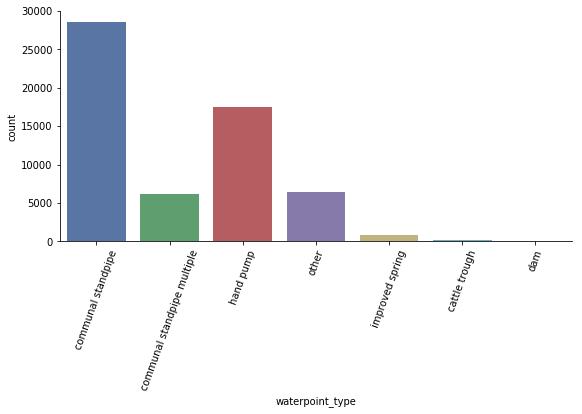

In [88]:
# plot
g = sns.factorplot('waterpoint_type', data=train, aspect=2,
                   kind="count", palette='deep')

g.set_xticklabels(step=1, rotation=70);

### waterpoint_type_group

In [89]:
# overall info
train.waterpoint_type_group.describe()

count                  59400
unique                     6
top       communal standpipe
freq                   34625
Name: waterpoint_type_group, dtype: object

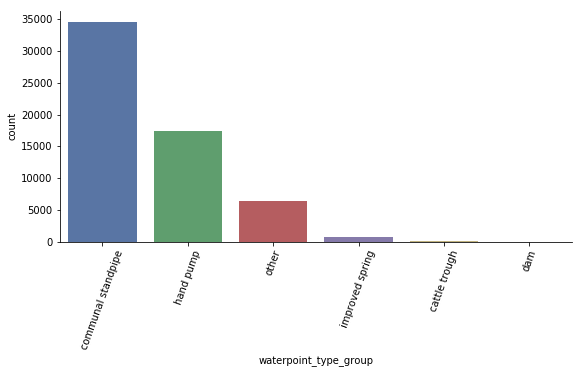

In [90]:
# plot
g = sns.factorplot('waterpoint_type_group', data=train, aspect=2,
                   kind="count", palette='deep')

g.set_xticklabels(step=1, rotation=70)

In [91]:
# value Count -> like waterpoint_type but with less levels
train.waterpoint_type_group.value_counts()

communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64

In [92]:
# missing values
all_data.waterpoint_type.isnull().sum()

0

## time_parameters

### date_recorded

In [93]:
# Overall info
train.date_recorded.describe()

count                   59400
unique                    356
top       2011-03-15 00:00:00
freq                      572
first     2002-10-14 00:00:00
last      2013-12-03 00:00:00
Name: date_recorded, dtype: object

In [94]:
# Earliest date_recorded
train.date_recorded.min()

Timestamp('2002-10-14 00:00:00')

In [95]:
# Latest date_recorded
train.date_recorded.max()

Timestamp('2013-12-03 00:00:00')

In [96]:
# Value count
train.date_recorded.value_counts().nlargest(20)

2011-03-15    572
2011-03-17    558
2013-02-03    546
2011-03-14    520
2011-03-16    513
2011-03-18    497
2011-03-19    466
2013-02-04    464
2013-01-29    459
2011-03-04    458
2013-02-14    444
2013-01-24    435
2011-03-05    434
2013-02-15    429
2013-03-15    428
2011-03-11    426
2013-01-30    421
2013-02-16    418
2011-03-23    417
2011-03-09    416
Name: date_recorded, dtype: int64

In [97]:
# Missing values
all_data.date_recorded.isnull().sum()

0

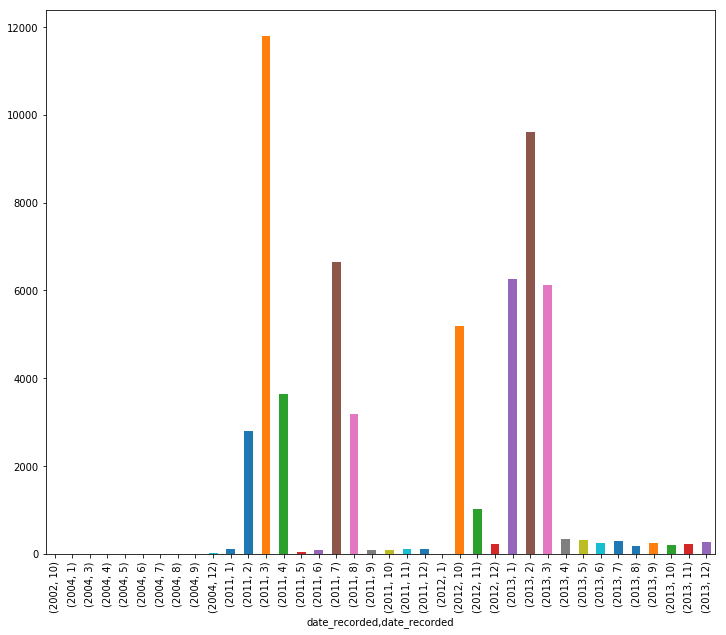

In [98]:
# distrubution of date_recorded
train.groupby([train.date_recorded.dt.year,
               train.date_recorded.dt.month]).date_recorded.count().plot(kind='bar', x='', figsize=(12, 10));

In [99]:
# Filter data based on records prior 2004 -> drop record
train[train.date_recorded < '2004-01-01']

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
14428,0.0,2002-10-14,Undp,0,BESADA,33.688109,-3.740579,Shule,0,Internal,Mwawe Ja,Shinyanga,17,8,Kishapu,Ukenyenge,0,False,GeoData Consultants Ltd,Parastatal,NaN,False,0,gravity,gravity,gravity,parastatal,parastatal,unknown,unknown,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other,functional


In [100]:
# Drop record from train 2002 
all_data.drop(14428, inplace=True)

## Demographic Parameters

### population


In [101]:
# overall info
train.population.describe()

count    59400.000000
mean       179.909983
std        471.482176
min          0.000000
25%          0.000000
50%         25.000000
75%        215.000000
max      30500.000000
Name: population, dtype: float64

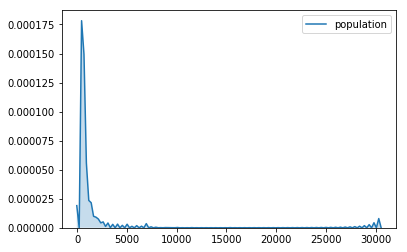

In [102]:
# KDEplot -> alot of zeros
sns.kdeplot(train.population, shade=True)

In [103]:
# zero values
all_data[all_data.population == 0].population.count()

26833

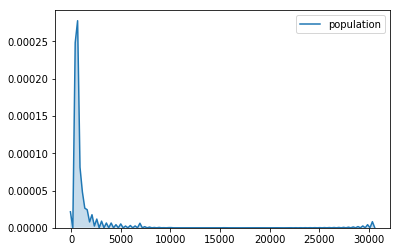

In [104]:
# KDEplot population > 0 -> still bad very wide range....
sns.kdeplot(train[train.population > 0].population, shade=True)

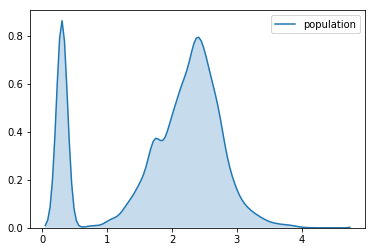

In [105]:
# KDEplot log10 (population > 0) 
sns.kdeplot(np.log10(train[train.population > 0].population + 1), shade=True)

In [106]:
# -> better display 
# -> create new variable in log transformation 
# -> impute zero values ?

/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


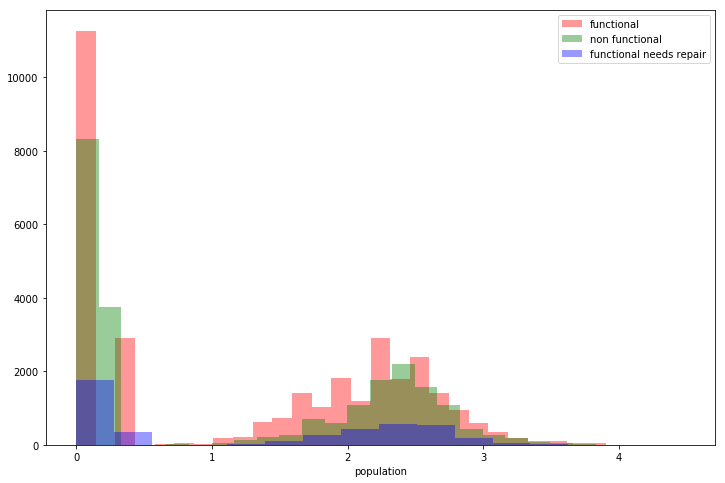

In [107]:
# See distrubtion of log population vs status_group -> no clear relationship
plot_df = pd.concat([train.status_group, np.log10(train.population + 1)], axis=1)

fig, ax = plt.subplots(figsize=(12, 8))

sns.distplot(plot_df[(plot_df.status_group == 'functional')].population,
             kde=False, color='r',
             label="functional")

sns.distplot(plot_df[(plot_df.status_group == 'non functional')].population,
             kde=False, color='g',
             label="non functional")

sns.distplot(plot_df[(plot_df.status_group == 'functional needs repair')].population,
             kde=False, color='b',
             label="functional needs repair")

plt.legend();

## Economic Parameters

### payment_type

In [108]:
# overall info
train.payment_type.describe()

count         59400
unique            7
top       never pay
freq          25348
Name: payment_type, dtype: object

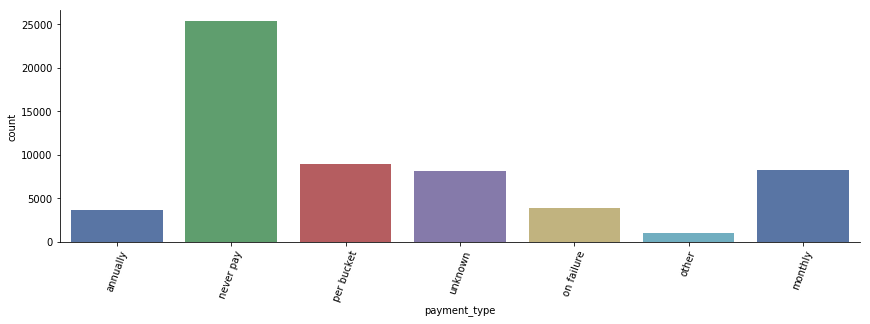

In [109]:
# plot
g = sns.factorplot('payment_type', data=train, aspect=3,
                   kind="count", palette='deep')

g.set_xticklabels(step=1, rotation=70);

In [110]:
# value Count
train.payment_type.value_counts()


never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64

In [111]:
# missing Values
all_data.payment_type.isnull().sum()

0

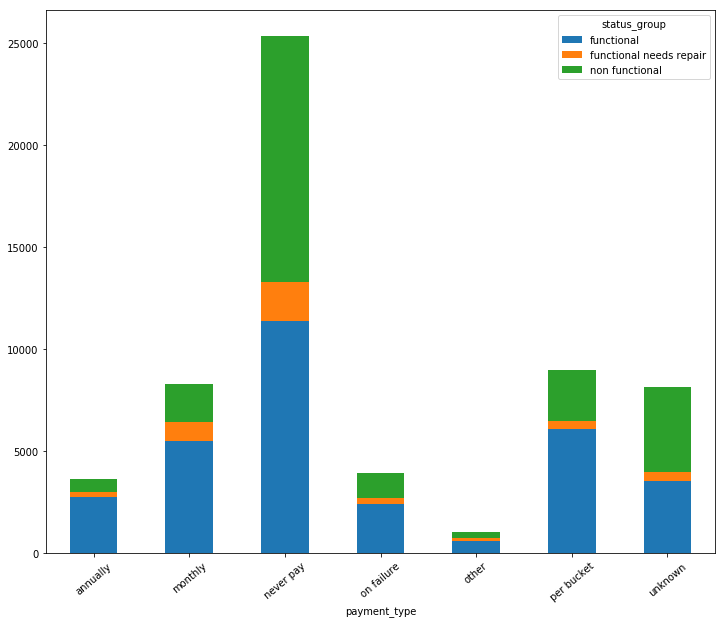

In [112]:
# Stacked plot with status_group -> unknown higher proportion of non-functional
plot_df = train.groupby(['payment_type', 'status_group']) \
               .quantity \
               .count() \
               .unstack()

plot_df.plot(kind='bar', stacked=True, figsize=(12, 10), rot=40);

In [113]:
train.groupby(['payment_type', 'status_group']) \
               .quantity \
               .count() \
               .unstack()

status_group,functional,functional needs repair,non functional
payment_type,,,
annually,2740,247,655
monthly,5482,927,1891
never pay,11379,1907,12062
on failure,2429,277,1208
other,611,118,325
per bucket,6090,409,2486
unknown,3528,432,4197


In [114]:
# higher prop non-functional:
# never pay 
# unknown

### payment

In [115]:
# overall info
train.payment.describe()

count         59400
unique            7
top       never pay
freq          25348
Name: payment, dtype: object

In [116]:
# value Count -> same as payment_type
train.payment.value_counts()

never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: payment, dtype: int64

## Legal Parameters
### permit


In [117]:
# overall info
train.permit.describe()

count     56344
unique        2
top        True
freq      38852
Name: permit, dtype: object

In [118]:
# value Count
train.permit.value_counts()

True     38852
False    17492
Name: permit, dtype: int64

In [119]:
# missing Values -> need to impute! -> probably new level unknown
all_data.permit.isnull().sum()

3793

In [120]:
# -> make binary permit, no permit

## Geographic Parameters
### district_code

In [121]:
# overall info
train.district_code.describe()

count    59400.000000
mean         5.629747
std          9.633649
min          0.000000
25%          2.000000
50%          3.000000
75%          5.000000
max         80.000000
Name: district_code, dtype: float64

In [122]:
# value Count -> encoded, perfer names, thus propably drop variable
train.district_code.value_counts()

1     12203
2     11173
3      9998
4      8999
5      4356
6      4074
7      3343
8      1043
30      995
33      874
53      745
43      505
13      391
23      293
63      195
62      109
60       63
0        23
80       12
67        6
Name: district_code, dtype: int64

In [123]:
# missing Values
all_data.district_code.isnull().sum()

0

### region_code

In [124]:
# overall info
train.region_code.describe()

count    59400.000000
mean        15.297003
std         17.587406
min          1.000000
25%          5.000000
50%         12.000000
75%         17.000000
max         99.000000
Name: region_code, dtype: float64

In [125]:
# value Count -> encoded, perfer names, thus propably drop variable
train.region_code.value_counts()

11    5300
17    5011
12    4639
3     4379
5     4040
18    3324
19    3047
2     3024
16    2816
10    2640
4     2513
1     2201
13    2093
14    1979
20    1969
15    1808
6     1609
21    1583
80    1238
60    1025
90     917
7      805
99     423
9      390
24     326
8      300
40       1
Name: region_code, dtype: int64

In [126]:
# missing Values
all_data.region_code.isnull().sum()

0

### region

In [127]:
# overall info
train.region.describe()

count      59400
unique        21
top       Iringa
freq        5294
Name: region, dtype: object

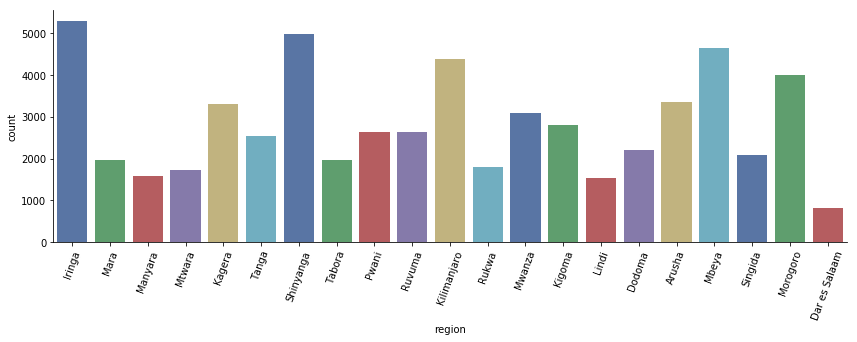

In [128]:
# plot
g = sns.factorplot('region', data=train, aspect=3,
                   kind="count", palette='deep')

g.set_xticklabels(step=1, rotation=70);

In [129]:
# missing Values
all_data.region.isnull().sum()

0

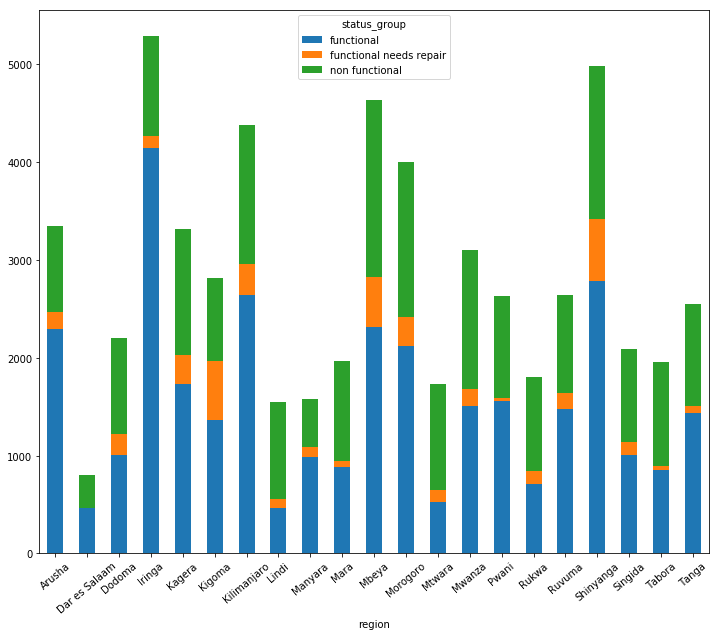

In [130]:
# Stacked plot with status_group -> unknown higher proportion of non-functional
plot_df = train.groupby(['region', 'status_group']) \
               .quantity \
               .count() \
               .unstack()

plot_df.plot(kind='bar', stacked=True, figsize=(12, 10), rot=40);

In [131]:
# Some regions with less data have higher proportions of non-functional

In [132]:
train.groupby(['region', 'status_group']) \
               .quantity \
               .count() \
               .unstack()

status_group,functional,functional needs repair,non functional
region,,,
Arusha,2294,175,881
Dar es Salaam,461,3,341
Dodoma,1009,209,983
Iringa,4141,123,1030
Kagera,1727,304,1285
Kigoma,1363,603,850
Kilimanjaro,2640,322,1417
Lindi,460,93,993
Manyara,987,96,500


### lga (town name)

In [133]:
# overall info
train.lga.describe()

count      59400
unique       125
top       Njombe
freq        2503
Name: lga, dtype: object

In [134]:
# value Count
train.lga.value_counts()

Njombe              2503
Arusha Rural        1252
Moshi Rural         1251
Bariadi             1177
Rungwe              1106
Kilosa              1094
Kasulu              1047
Mbozi               1034
Meru                1009
Bagamoyo             997
Singida Rural        995
Kilombero            959
Same                 877
Kibondo              874
Kyela                859
Kahama               836
Kigoma Rural         824
Magu                 824
Maswa                809
Karagwe              771
Mbinga               750
Iringa Rural         728
Serengeti            716
Namtumbo             694
Lushoto              694
Songea Rural         693
Mpanda               679
Mvomero              671
Ngara                669
Ulanga               665
                    ... 
Ileje                231
Bahi                 224
Kisarawe             223
Temeke               215
Rorya                210
Tarime               209
Ngorongoro           201
Kiteto               193
Shinyanga Urban      191


In [135]:
# missing Values
all_data.lga.isnull().sum()

0

### ward

In [136]:
# overall info
train.ward.describe()

count     59400
unique     2092
top       Igosi
freq        307
Name: ward, dtype: object

In [137]:
# value Count
train.ward.value_counts()

Igosi               307
Imalinyi            252
Siha Kati           232
Mdandu              231
Nduruma             217
Kitunda             203
Mishamo             203
Msindo              201
Chalinze            196
Maji ya Chai        190
Usuka               187
Ngarenanyuki        172
Chanika             171
Vikindu             162
Mtwango             153
Matola              145
Zinga/Ikerege       141
Wanging'ombe        139
Maramba             139
Itete               137
Magomeni            135
Ifakara             134
Kikatiti            134
Olkokola            133
Maposeni            130
Mvomero             129
Igongolo            129
Mlangali            125
Nkoma               122
Nkungulu            121
                   ... 
Kirongo               1
Uwanja wa Ndege       1
Thawi                 1
Mawenzi               1
Kinungu               1
Igogo                 1
Sungwisi              1
Ukata                 1
Kihangimahuka         1
Mkumbi                1
Machinjioni     

In [138]:
# missing Values
all_data.ward.isnull().sum()

0

### subvillage

In [139]:
# overall info
train.subvillage.describe()

count        59029
unique       19287
top       Madukani
freq           508
Name: subvillage, dtype: object

In [140]:
# value Count -> some 1 char names...
train.subvillage.value_counts().head(20)

Madukani      508
Shuleni       506
Majengo       502
Kati          373
Mtakuja       262
Sokoni        232
M             187
Muungano      172
Mbuyuni       164
Mlimani       152
Songambele    147
Miembeni      134
Msikitini     134
1             132
Kibaoni       114
Kanisani      111
I             109
Mapinduzi     109
Mjini         108
Mjimwema      108
Name: subvillage, dtype: int64

In [141]:
# find 1 char subvillages -> probably impute for 'unknown'
train[train.subvillage.str.len() < 3].groupby('subvillage').subvillage.count().nlargest(10)

subvillage
M     187
1     132
I     109
K      77
L      32
U      31
S      30
N      26
Rc     20
J      10
Name: subvillage, dtype: int64

In [142]:
# missing Values -> need to be imputed
all_data.subvillage.isnull().sum()

470

### latitude

In [143]:
# overall info
train.latitude.describe()

count    5.940000e+04
mean    -5.706033e+00
std      2.946019e+00
min     -1.164944e+01
25%     -8.540621e+00
50%     -5.021597e+00
75%     -3.326156e+00
max     -2.000000e-08
Name: latitude, dtype: float64

In [144]:
# min
train.latitude.min()

-11.64944018

In [145]:
# max
train.latitude.max()

# true latitude -1 to -12 -> 0 values need to be imputed

-2e-08

In [146]:
# missing Values
all_data.latitude.isnull().sum()

0

### longitude

In [147]:
# overall info
train.longitude.describe()

count    59400.000000
mean        34.077427
std          6.567432
min          0.000000
25%         33.090347
50%         34.908743
75%         37.178387
max         40.345193
Name: longitude, dtype: float64

In [148]:
# value Count -> alot of zeros
train.longitude.value_counts().head(20)

0.000000     1812
37.540901       2
33.010510       2
39.093484       2
32.972719       2
33.006275       2
39.103950       2
37.542785       2
36.802490       2
39.098374       2
33.090347       2
33.005032       2
32.978062       2
39.088875       2
31.619530       2
39.093095       2
39.105307       2
32.936689       2
32.987511       2
39.090880       2
Name: longitude, dtype: int64

In [149]:
# true tanzinia longitude range 29-39 -> must impute zeros ....

In [150]:
# count zeros
train[train.longitude == 0].longitude.count()

1812

In [151]:
# missing Values
all_data.longitude.isnull().sum()

0

## funder

In [152]:
# overall info
train.funder.describe()

count                      55765
unique                      1897
top       Government Of Tanzania
freq                        9084
Name: funder, dtype: object

In [153]:
# value Count -> probably wrong spellings for same levels -> shirnk levels
train.funder.value_counts().nlargest(10)

Government Of Tanzania    9084
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
Kkkt                      1287
World Vision              1246
Unicef                    1057
Tasaf                      877
District Council           843
Name: funder, dtype: int64

In [154]:
# subset for 5 char funder -> probably wrong spellings for same levels 
# -> count abbreviate 5 letter levels
train.funder.str[:5].value_counts().count()

1441

In [155]:
# subset for 5 char funder -> probably wrong spellings for same levels
# -> top 10 abbreviate 5 letter levels
train.groupby(train.funder.str[:5]).funder.count().nlargest(10)

funder
Gover    9123
Danid    3117
World    2633
Hesaw    2215
Rwssp    1382
Kkkt     1287
Unice    1200
Priva    1144
Water    1095
Tasaf     910
Name: funder, dtype: int64

In [156]:
# 400 less levels

### installer

In [157]:
# overall info
train.installer.describe()

count     55745
unique     2145
top         DWE
freq      17402
Name: installer, dtype: object

In [158]:
# value Count
train.installer.value_counts().nlargest(10)

DWE                   17402
Government             1825
RWE                    1206
Commu                  1060
DANIDA                 1050
KKKT                    898
Hesawa                  840
0                       777
TCRS                    707
Central government      622
Name: installer, dtype: int64

In [159]:
# subset for 3 char funder -> probably wrong spellings for same levels 
# -> count abbreviate 5 letters levels
train.installer.str[:5].value_counts().count()

1607

In [160]:
# subset for 3 char funder -> probably wrong spellings for same levels 
# -> show top 10 abbreviated 5 letters installer
train.groupby(train.installer.str[:5]).installer.count().nlargest(10)

installer
DWE      17402
Gover     2219
Commu     1667
DANID     1604
Distr     1362
RWE       1206
Centr     1035
World      923
KKKT       898
Hesaw      841
Name: installer, dtype: int64

In [161]:
# 500 levels less -> create new feature with abbreviated names

In [162]:
# missing Values -> need to impute -> 'unknown'
all_data.installer.isnull().sum()

4532

### management

In [163]:
# overall info
train.management.describe()

count     59400
unique       12
top         vwc
freq      40507
Name: management, dtype: object

In [164]:
# value Count
train.management.value_counts()

vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64

In [165]:
# missing Values
all_data.management.isnull().sum()

0

### management_group

In [166]:
# overall info
train.management_group.describe()

count          59400
unique             5
top       user-group
freq           52490
Name: management_group, dtype: object

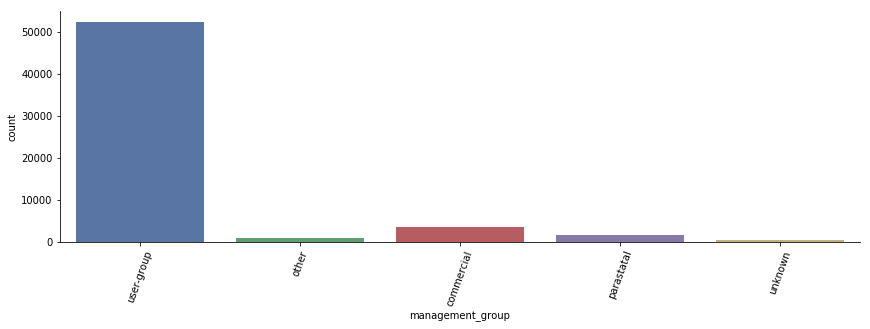

In [167]:
# plot
g = sns.factorplot('management_group', data=train, aspect=3,
                   kind="count", palette='deep')

g.set_xticklabels(step=1, rotation=70);

In [168]:
# value Count -> less levels than management
train.management_group.value_counts()

user-group    52490
commercial     3638
parastatal     1768
other           943
unknown         561
Name: management_group, dtype: int64

In [169]:
# missing Values
all_data.management_group.isnull().sum()

0

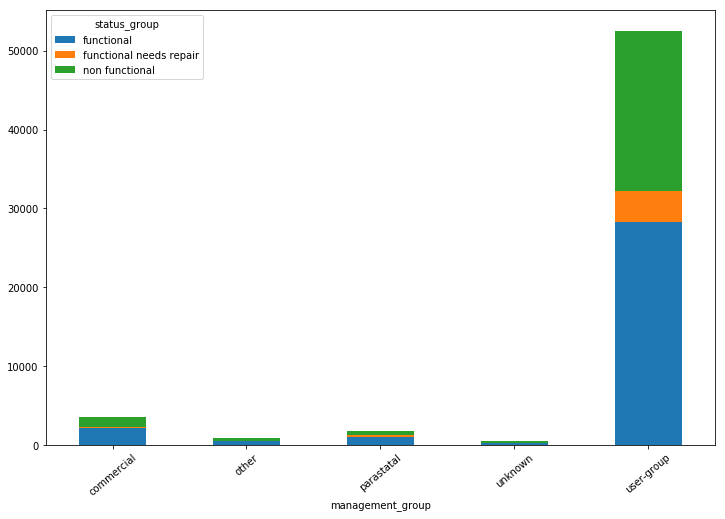

In [170]:
# Stacked plot with status_group -> unknown higher proportion of non-functional
plot_df = train.groupby(['management_group', 'status_group']) \
               .quantity \
               .count() \
               .unstack()

plot_df.plot(kind='bar', stacked=True, figsize=(12, 8), rot=40);

In [171]:
# Stacked plot with status_group
train.groupby(['management_group', 'status_group']) \
               .quantity \
               .count() \
               .unstack()

status_group,functional,functional needs repair,non functional
management_group,,,
commercial,2235,117,1286
other,528,56,359
parastatal,1020,211,537
unknown,224,27,310
user-group,28252,3906,20332


In [172]:
# unknown higher proportion of non-functional

In [173]:
# missing Values
all_data.management_group.isnull().sum()

0

### scheme_name

In [174]:
# overall info
train.scheme_name.describe()

count     31234
unique     2696
top           K
freq        682
Name: scheme_name, dtype: object

In [175]:
# value Count
train.scheme_name.value_counts().nlargest(10)

K                              682
None                           644
Borehole                       546
Chalinze wate                  405
M                              400
DANIDA                         379
Government                     320
Ngana water supplied scheme    270
wanging'ombe water supply s    261
wanging'ombe supply scheme     234
Name: scheme_name, dtype: int64

In [176]:
# subset for 3 char scheme_name -> probably wrong spellings for same levels 
# -> count abbreviate 5 letters levels
train.scheme_name.str[:5].value_counts().count()

1941

In [177]:
# subset for 3 char scheme_name -> probably wrong spellings for same levels 
# -> show top 10 abbreviated 5 letters subvillages
train.groupby(train.scheme_name.str[:5]).scheme_name.count().nlargest(10)

scheme_name
Mradi    1095
K         682
None      644
Boreh     550
wangi     511
Chali     406
M         400
DANID     379
Gover     321
Mkong     309
Name: scheme_name, dtype: int64

In [178]:
# missing Values -> high proportion of NaNs
all_data.scheme_name.isnull().sum()

35257

In [179]:
# dummy variable: 1=name, 0=no name or other imputate new level 'unknown'

### scheme_management

In [180]:
train.scheme_management.describe()

count     55523
unique       12
top         VWC
freq      36793
Name: scheme_management, dtype: object

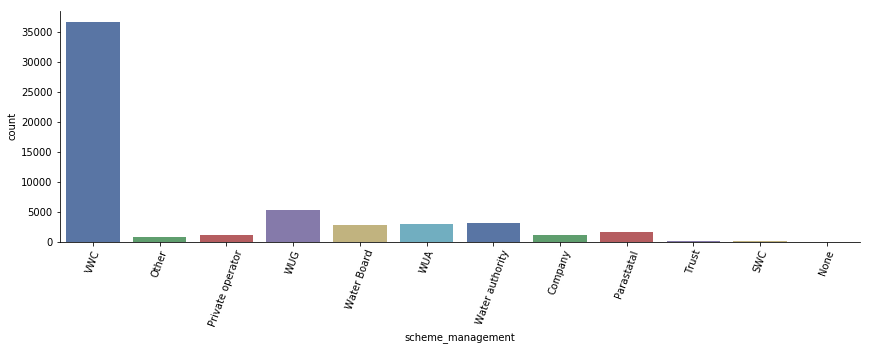

In [181]:
# plot 
g = sns.factorplot('scheme_management', data=train, aspect=3,
                   kind="count", palette='deep')

g.set_xticklabels(step=1, rotation=70);

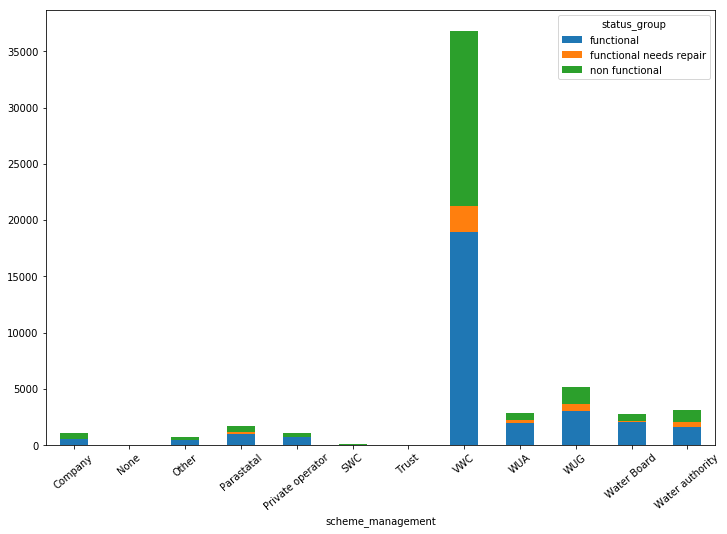

In [182]:
# Stacked plot with status_group -> unknown higher proportion of non-functional
plot_df = train.groupby(['scheme_management', 'status_group']) \
               .quantity \
               .count() \
               .unstack()

plot_df.plot(kind='bar', stacked=True, figsize=(12, 8), rot=40);

In [183]:
train.groupby(['scheme_management', 'status_group']) \
               .quantity \
               .count() \
               .unstack()

status_group,functional,functional needs repair,non functional
scheme_management,,,
Company,534.0,37.0,490.0
None,1.0,NaN,NaN
Other,458.0,22.0,286.0
Parastatal,966.0,202.0,512.0
Private operator,729.0,23.0,311.0
SWC,20.0,1.0,76.0
Trust,46.0,5.0,21.0
VWC,18960.0,2334.0,15499.0
WUA,1995.0,239.0,649.0


In [184]:
# -> more granular than management_group (drop variable)

### recorded_by

In [185]:
train.recorded_by.describe()

count                       59400
unique                          1
top       GeoData Consultants Ltd
freq                        59400
Name: recorded_by, dtype: object

In [186]:
# one level -> drop variable